In [1]:
# Config & imports

import os, json, numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks

# ---- data & outputs ----
DATA_DIR   = "../generated/bulk_50k" 
OUT_DIR    = "../data/models/mlp"
PLOT_DIR   = "../plots"
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(PLOT_DIR, exist_ok=True)

# ---- training ----
EPOCHS      = 200
BATCH_SIZE  = 256
LR          = 1e-3
PATIENCE    = 15
RANDOM_SEED = 42

# ---- split ratios (train/val/test sum to 1.0) ----
TRAIN_FRAC = 0.85
VAL_FRAC   = 0.10
TEST_FRAC  = 0.05

# ---- MLP widths ----
WIDTHS  = [512, 256, 128]
DROPOUT = 0.15

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

print("TF:", tf.__version__)


2025-11-27 15:43:02.467740: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-27 15:43:02.543138: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TF: 2.20.0


2025-11-27 15:43:04.256736: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# Load shards (NPZ) → X (N,L), y (N,)

meta_path = os.path.join(DATA_DIR, "meta.json")
with open(meta_path, "r") as f:
    meta = json.load(f)

print({k: meta[k] for k in ["n_samples","n_shards","shard_size","n_points"]})

shards = sorted([os.path.join(DATA_DIR, f)
                 for f in os.listdir(DATA_DIR) if f.endswith(".npz")])
assert len(shards) == meta["n_shards"], "Shard count mismatch."

X_list, y_list = [], []
for sp in shards:
    d = np.load(sp)
    X_list.append(d["X"])            # (S,L)
    y_list.append(d["y_hbn"])        # (S,)
    wn = d["wn"]                     # (L,)
X = np.vstack(X_list).astype(np.float32)
y = np.concatenate(y_list).astype(np.float32)
print("Loaded:", X.shape, y.shape, "axis:", wn.shape)


{'n_samples': 50000, 'n_shards': 10, 'shard_size': 5000, 'n_points': 3323}
Loaded: (50000, 3323) (50000,) axis: (3323,)


In [3]:
# Split train/val/test sets

assert abs(TRAIN_FRAC + VAL_FRAC + TEST_FRAC - 1.0) < 1e-8

# first split train vs (val+test)
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=(1.0-TRAIN_FRAC), random_state=RANDOM_SEED, shuffle=True
)

# then split (val+test) into val and test
val_ratio_of_tmp = VAL_FRAC / (VAL_FRAC + TEST_FRAC)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=(1.0 - val_ratio_of_tmp), random_state=RANDOM_SEED, shuffle=True
)

print("train:", X_train.shape, "val:", X_val.shape, "test:", X_test.shape)


train: (42499, 3323) val: (5000, 3323) test: (2501, 3323)


In [4]:
# Standardize using training stats

mean = X_train.mean(axis=0, dtype=np.float64)
std  = X_train.std(axis=0, dtype=np.float64)
std[std < 1e-12] = 1.0

X_train_s = ((X_train - mean) / std).astype(np.float32)
X_val_s   = ((X_val   - mean) / std).astype(np.float32)
X_test_s  = ((X_test  - mean) / std).astype(np.float32)

print("Standardized shapes:", X_train_s.shape, X_val_s.shape, X_test_s.shape)


Standardized shapes: (42499, 3323) (5000, 3323) (2501, 3323)


In [5]:
# Build model (MLP)

def build_mlp(input_dim, widths, dropout=0.0, lr=1e-3):
    inp = keras.Input(shape=(input_dim,))
    x = inp
    for w in widths:
        x = layers.Dense(w, activation="relu")(x)
        if dropout > 0:
            x = layers.Dropout(dropout)(x)
    out = layers.Dense(1, activation="linear")(x)
    model = keras.Model(inp, out)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                  loss="mse", metrics=["mae"])   # <= your working line
    return model

model = build_mlp(X_train_s.shape[1], WIDTHS, dropout=DROPOUT, lr=LR)
model.summary()


I0000 00:00:1764225791.569554  918668 gpu_device.cc:2411] Ignoring visible gpu device (device: 4, name: NVIDIA T400 4GB, pci bus id: 0000:e3:00.0, compute capability: 7.5) with core count: 6. The minimum required count is 8. You can adjust this requirement with the env var TF_MIN_GPU_MULTIPROCESSOR_COUNT.
I0000 00:00:1764225792.199048  918668 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 17432 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:31:00.0, compute capability: 8.6
I0000 00:00:1764225792.199923  918668 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 20126 MB memory:  -> device: 1, name: NVIDIA RTX A5000, pci bus id: 0000:4b:00.0, compute capability: 8.6
I0000 00:00:1764225792.200816  918668 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 20142 MB memory:  -> device: 2, name: NVIDIA RTX A5000, pci bus id: 0000:b1:00.0, compute capability: 8.6
I0000 

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3323)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,701,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,866,241 (7.12 MB)

 Trainable params: 1,866,241 (7.12 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Training

es  = callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True)
rlr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5,
                                  patience=max(5, PATIENCE//3), min_lr=1e-6)

hist = model.fit(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks=[es, rlr]
)


Epoch 1/200


2025-11-27 15:43:15.148414: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f44b000ac30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-27 15:43:15.148470: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2025-11-27 15:43:15.148485: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (1): NVIDIA RTX A5000, Compute Capability 8.6
2025-11-27 15:43:15.148497: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (2): NVIDIA RTX A5000, Compute Capability 8.6
2025-11-27 15:43:15.148508: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (3): NVIDIA RTX A5000, Compute Capability 8.6
2025-11-27 15:43:15.205592: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-27 15:43:15.437332: I exter

 42/167 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 233.1407 - mae: 11.8007

I0000 00:00:1764225799.553160  919048 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


166/167 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 117.0346 - mae: 7.9927

2025-11-27 15:43:21.182800: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_156', 8 bytes spill stores, 8 bytes spill loads



167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 116.6699 - mae: 7.9784

2025-11-27 15:43:24.406652: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_28', 4 bytes spill stores, 4 bytes spill loads

2025-11-27 15:43:26.267893: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_21', 1568 bytes spill stores, 1296 bytes spill loads



167/167 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - loss: 56.1249 - mae: 5.6177 - val_loss: 19.3012 - val_mae: 3.3651 - learning_rate: 0.0010
Epoch 2/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 21.4040 - mae: 3.6154 - val_loss: 132.5668 - val_mae: 10.2443 - learning_rate: 0.0010
Epoch 3/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 26.6190 - mae: 4.0240 - val_loss: 12.8241 - val_mae: 2.9089 - learning_rate: 0.0010
Epoch 4/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 13.1788 - mae: 2.8596 - val_loss: 145.5637 - val_mae: 10.4697 - learning_rate: 0.0010
Epoch 5/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 32.5048 - mae: 4.3975 - val_loss: 20.9817 - val_mae: 3.9900 - learning_rate: 0.0010
Epoch 6/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 15.0099 - mae: 3.0372 - val_loss: 51.1789 - val_mae: 5.9295 - learning_rate: 0.0010
Epoch 7/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 10.8877 - mae: 2.6068 - val_loss: 40.6096 - val_mae: 5.3297 - learning_rate

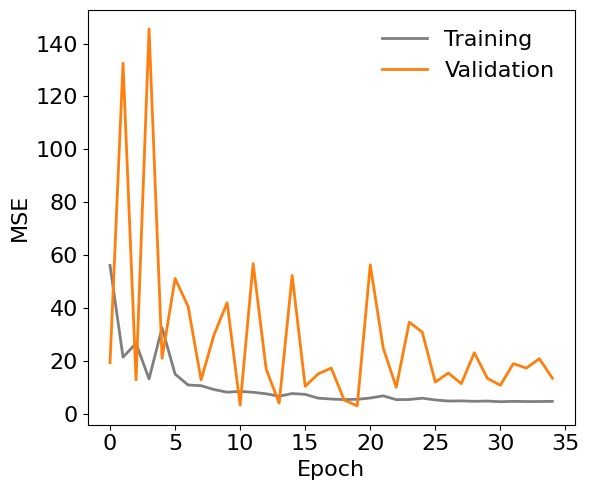

Saved: ../plots/fig3a.jpg


In [ ]:
# Learning curve

plt.figure(figsize=(6,5))

# custom line colors
TRAIN_COLOR = "tab:gray"
VAL_COLOR   = "tab:orange"

# plot curves
plt.plot(hist.history["loss"], label="Training", color=TRAIN_COLOR, lw=2)
plt.plot(hist.history["val_loss"], label="Validation", color=VAL_COLOR, lw=2)

# labels and ticks
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("MSE", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# legend font control
plt.legend(fontsize=16, loc="best", frameon=False)

plt.tight_layout()
lc_path = os.path.join(PLOT_DIR, "fig_s3a.jpg")
plt.savefig(lc_path, dpi=500)
plt.show()
print("Saved:", lc_path)


2025-11-27 15:44:03.015956: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-27 15:44:03.574315: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_25', 8 bytes spill stores, 8 bytes spill loads

2025-11-27 15:44:08.455341: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_25', 16 bytes spill stores, 16 bytes spill loads

2025-11-27 15:44:08.515601: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_25', 8 bytes spill

TRAIN  MAE=1.368  RMSE=1.722  R²=0.986
TEST  MAE=1.379  RMSE=1.724  R²=0.986


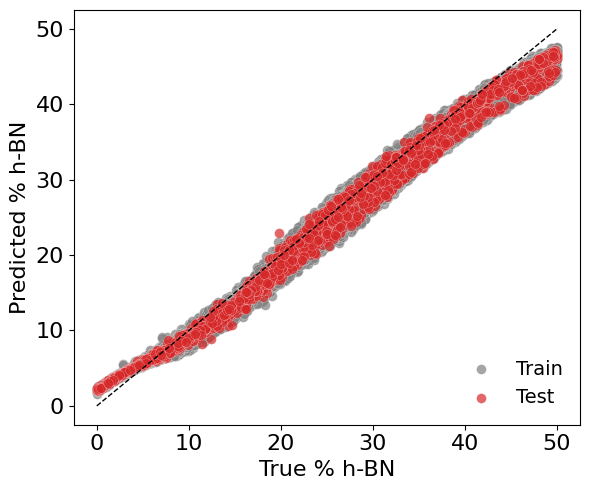

Saved: ../plots/fig3b.jpg


In [ ]:
# Combined Train & Test Parity Plot

def reg_metrics(y_true, y_pred, name=""):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(((y_true - y_pred)**2).mean())
    r2   = r2_score(y_true, y_pred)
    print(f"{name}  MAE={mae:.3f}  RMSE={rmse:.3f}  R²={r2:.3f}")
    return mae, rmse, r2

y_tr_pred = model.predict(X_train_s, verbose=0).ravel()
y_te_pred = model.predict(X_test_s,  verbose=0).ravel()

reg_metrics(y_train, y_tr_pred, "TRAIN")
reg_metrics(y_test,  y_te_pred, "TEST")


# ---- viz style (from your viz.txt) ----
FIGSIZE_PARITY = (6, 5)
DPI            = 500
FONT           = 16
SCATTER_ALPHA  = 0.7
SCATTER_SIZE   = 50
EDGE_W         = 0.2

plt.figure(figsize=FIGSIZE_PARITY)

# ---- Train scatter ----
plt.scatter(
    y_train, y_tr_pred,
    color="tab:gray", alpha=SCATTER_ALPHA,
    s=SCATTER_SIZE, edgecolor="w", linewidth=EDGE_W,
    label="Train"
)

# ---- Test scatter ----
plt.scatter(
    y_test, y_te_pred,
    color="tab:red", alpha=SCATTER_ALPHA,
    s=SCATTER_SIZE, edgecolor="w", linewidth=EDGE_W,
    label="Test"
)

# ---- Diagonal (perfect prediction) ----
mn = float(min(y_train.min(), y_test.min(), y_tr_pred.min(), y_te_pred.min()))
mx = float(max(y_train.max(), y_test.max(), y_tr_pred.max(), y_te_pred.max()))
plt.plot([mn, mx], [mn, mx], "k--", lw=1)

# ---- Labels & style ----
plt.xlabel("True % h-BN", fontsize=FONT)
plt.ylabel("Predicted % h-BN", fontsize=FONT)
plt.xticks(fontsize=FONT)
plt.yticks(fontsize=FONT)
plt.legend(fontsize=FONT-2, loc="lower right", frameon=False)

plt.tight_layout()

# ---- Save & show ----
path_combined = os.path.join(PLOT_DIR, "fig_s3b.jpg")
plt.savefig(path_combined, dpi=DPI)
plt.show()
print("Saved:", path_combined)


In [9]:
# Save model, scaler, meta (JSON)

MODEL_PATH = os.path.join(OUT_DIR, "ann_mlp.keras")
SCALER_NPZ = os.path.join(OUT_DIR, "scaler_mean_std.npz")
META_JSON  = os.path.join(OUT_DIR, "ann_meta.json")

model.save(MODEL_PATH)
np.savez_compressed(SCALER_NPZ, mean=mean.astype(np.float32), std=std.astype(np.float32))

meta_out = dict(
    model_type="mlp",
    input_points=X.shape[1],
    widths=WIDTHS, dropout=float(DROPOUT), lr=float(LR),
    batch_size=BATCH_SIZE, epochs=EPOCHS, patience=PATIENCE,
    data_dir=DATA_DIR
)
with open(META_JSON, "w") as f:
    json.dump(meta_out, f, indent=2)

print("Saved:", MODEL_PATH)
print("Saved:", SCALER_NPZ)
print("Saved:", META_JSON)


Saved: ../data/models/mlp/ann_mlp.keras
Saved: ../data/models/mlp/scaler_mean_std.npz
Saved: ../data/models/mlp/ann_meta.json
